# 0. Instalando as bibliotecas

Serão usadas as bibliotecas matplotlib, seaborn e pandas

In [ ]:
%pip install matplotlib seaborn pandas

# 1. Importação das bibliotecas e leitura das bases
Importamos o `pandas` para manipulação de dados, e lemos os arquivos CSV contendo dados climáticos e socioeconômicos.

In [1]:
import pandas as pd

base_climatica = pd.read_csv('base_climatica.csv')
base_socioeconomica = pd.read_csv('base_socioeconomica.csv')

# 2. Remoção de linhas duplicadas
Eliminamos registros duplicados nas duas bases.

In [3]:
base_climatica = base_climatica.drop_duplicates()
base_socioeconomica = base_socioeconomica.drop_duplicates()

# 3. Suavização de outliers na base climática
Tratamos valores extremos nas colunas usando a mediana das colunas como substituição.

In [4]:
mediana_chuvas_previstas = base_climatica['chuvas_previstas_mm'].median()
base_climatica['chuvas_previstas_mm'] = base_climatica['chuvas_previstas_mm'].apply(
    lambda x: mediana_chuvas_previstas if x < 5 else x)

mediana_chuvas_reais = base_climatica['chuvas_reais_mm'].median()
base_climatica['chuvas_reais_mm'] = base_climatica['chuvas_reais_mm'].apply(
    lambda x: mediana_chuvas_reais if x > 400 or x < 5 else x)

mediana_temperatura = base_climatica['temperatura_media_C'].median()
base_climatica['temperatura_media_C'] = base_climatica['temperatura_media_C'].apply(
    lambda x: mediana_temperatura if x > 40 or x < 15 else x)

mediana_indice_umidade_solo = base_climatica['indice_umidade_solo'].median()
base_climatica['indice_umidade_solo'] = base_climatica['indice_umidade_solo'].apply(
    lambda x: mediana_indice_umidade_solo if x > 100 or x < 5 else x)

# 4. Suavização de outliers na base socioeconômica
Realizamos o mesmo tratamento de outliers nas colunas relevantes da base socioeconômica.

In [5]:
mediana_producao_tons = base_socioeconomica['volume_producao_tons'].median()
base_socioeconomica['volume_producao_tons'] = base_socioeconomica['volume_producao_tons'].apply(
    lambda x: mediana_producao_tons if x > 50 or x < 5 else x)

mediana_incidencia_doencas = base_socioeconomica['incidencia_doencas'].median()
base_socioeconomica['incidencia_doencas'] = base_socioeconomica['incidencia_doencas'].apply(
    lambda x: mediana_incidencia_doencas if x > 6 else x)

# 5. Preenchimento de valores nulos com a média
Substituímos os valores nulos das colunas selecionadas com a média da respectiva coluna.

In [7]:
base_climatica_cols_com_nulos = ["chuvas_reais_mm", "temperatura_media_C", "indice_umidade_solo"]
for col in base_climatica_cols_com_nulos:
    base_climatica[col] = base_climatica[col].fillna(base_climatica[col].mean())

base_socioeconomica_cols_com_nulos = ["volume_producao_tons", "incidencia_doencas"]
for col in base_socioeconomica_cols_com_nulos:
    base_socioeconomica[col] = base_socioeconomica[col].fillna(base_socioeconomica[col].mean())

# 6. Padronização de colunas com respostas "sim" ou "nao"
Normalizamos os valores de colunas categóricas que contêm variações de respostas "sim" e "não".

In [8]:
base_climatica['variacao_climatica'] = base_climatica['variacao_climatica'].str.lower().str.strip().apply(
    lambda x: 'nao' if x.startswith('n') else ('sim' if x.startswith('s') else pd.NA))

base_socioeconomica['acesso_agua_potavel'] = base_socioeconomica['acesso_agua_potavel'].str.lower().str.strip().apply(
    lambda x: 'nao' if x.startswith('n') else ('sim' if x.startswith('s') else pd.NA))

# 7. Conversão do tipo da coluna data
Convertendo a coluna "data" para o tipo `datetime`.

In [9]:
for df in (base_climatica, base_socioeconomica):
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d', errors='coerce')

# 8. Junção das bases
Unimos as duas bases usando a coluna "data" como chave e organizamos pela data.

In [10]:
base_completa = pd.merge(base_climatica, base_socioeconomica, on='data', how='inner', suffixes=('_climatica', '_socio'))
base_completa = base_completa.sort_values('data').reset_index(drop=True)

# 9. Importação das bibliotecas de vizualização

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 10. Visualização: Chuvas Reais vs Previstas
Gráfico de linhas comparando chuvas previstas e reais ao longo do tempo.

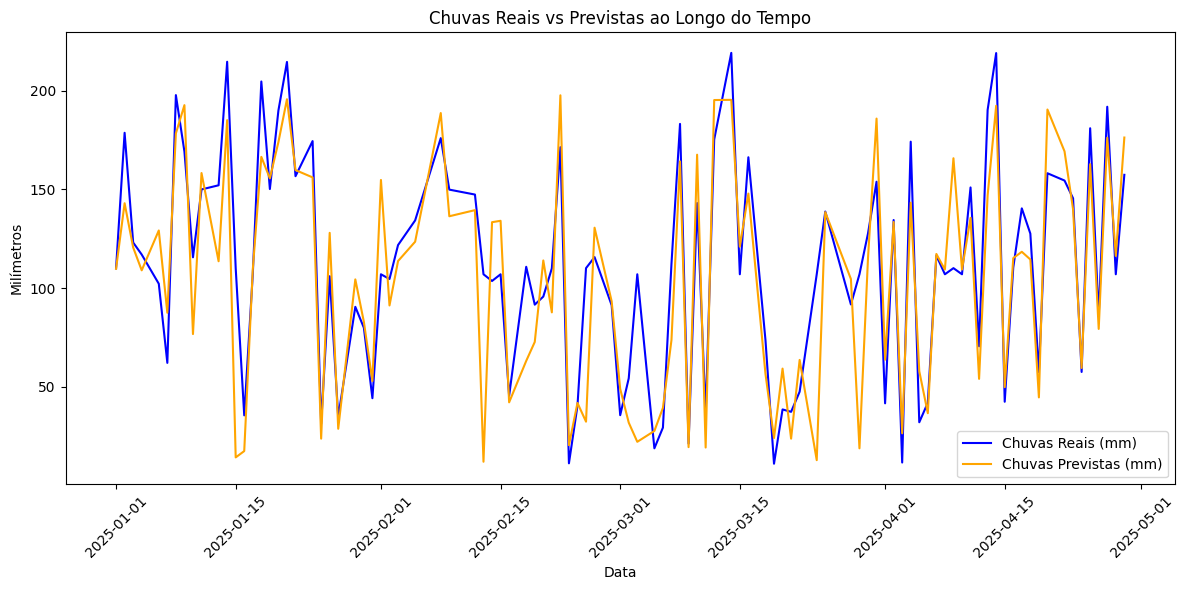

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=base_completa, x='data', y='chuvas_reais_mm', label='Chuvas Reais (mm)', color='blue')
sns.lineplot(data=base_completa, x='data', y='chuvas_previstas_mm', label='Chuvas Previstas (mm)', color='orange')
plt.title('Chuvas Reais vs Previstas ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Milímetros')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('chuvas_reais_vs_previstas.png')
plt.show()

# 11. Visualização: Temperatura vs Umidade do Solo
Gráfico de dispersão com linha de tendência para verificar relação entre temperatura e umidade do solo.

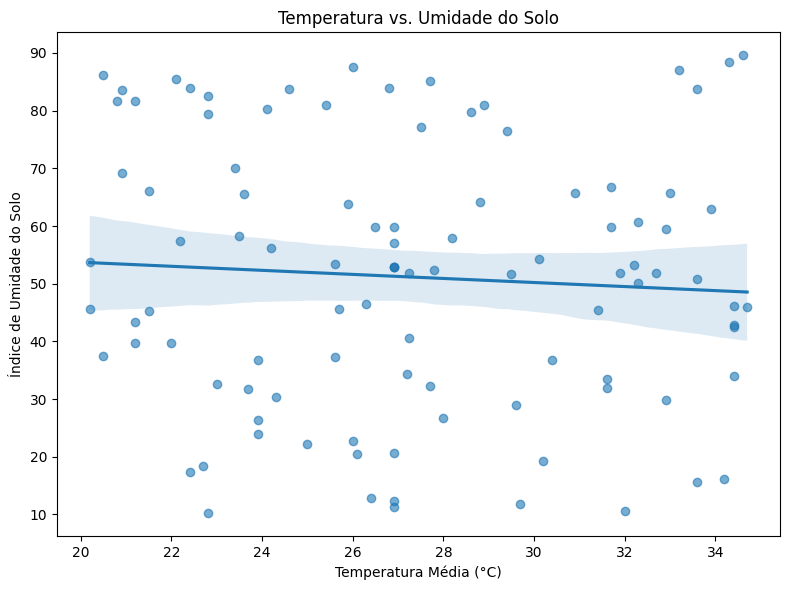

In [15]:
plt.figure(figsize=(8, 6))
sns.regplot(data=base_completa, x="temperatura_media_C", y="indice_umidade_solo", scatter_kws={'alpha':0.6})
plt.title("Temperatura vs. Umidade do Solo")
plt.xlabel("Temperatura Média (°C)")
plt.ylabel("Índice de Umidade do Solo")
plt.tight_layout()
plt.show()

# 12. Visualização: Produção por Faixa de Umidade do solo
Agrupamos os dados por quartis de umidade e comparamos a produção média em cada faixa.

C:\Users\usuario\AppData\Local\Temp\ipykernel_15568\2876949164.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_producao_por_umidade = base_umidade.groupby('faixa_umidade')['volume_producao_tons'].mean().reset_index()


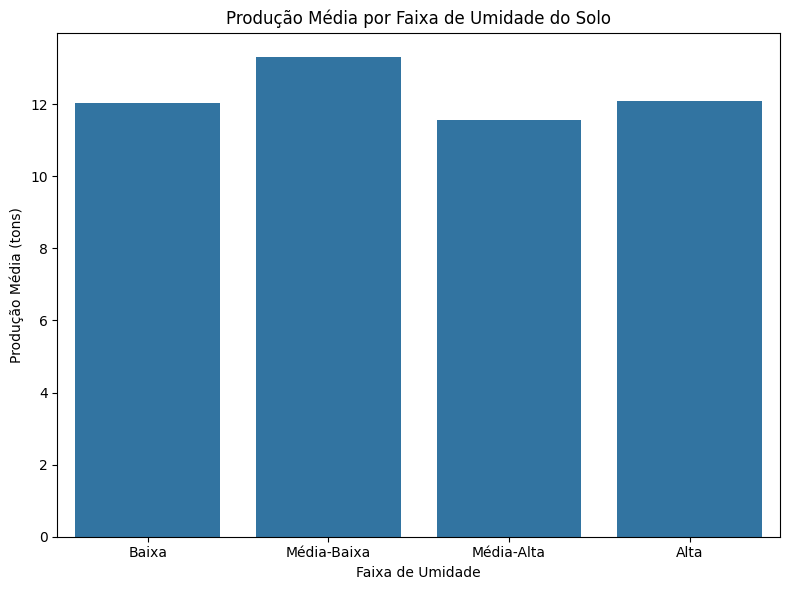

In [23]:
base_umidade = base_completa.copy()
base_umidade['faixa_umidade'] = pd.qcut(base_umidade['indice_umidade_solo'], q=4, labels=["Baixa", "Média-Baixa", "Média-Alta", "Alta"])
media_producao_por_umidade = base_umidade.groupby('faixa_umidade')['volume_producao_tons'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=media_producao_por_umidade, x='faixa_umidade', y='volume_producao_tons')
plt.title("Produção Média por Faixa de Umidade do Solo")
plt.xlabel("Faixa de Umidade")
plt.ylabel("Produção Média (tons)")
plt.tight_layout()
plt.show()

# 13. Visualização: Doenças por Faixa de Temperatura
Boxplot para mostrar como a incidência de doenças varia com a temperatura.

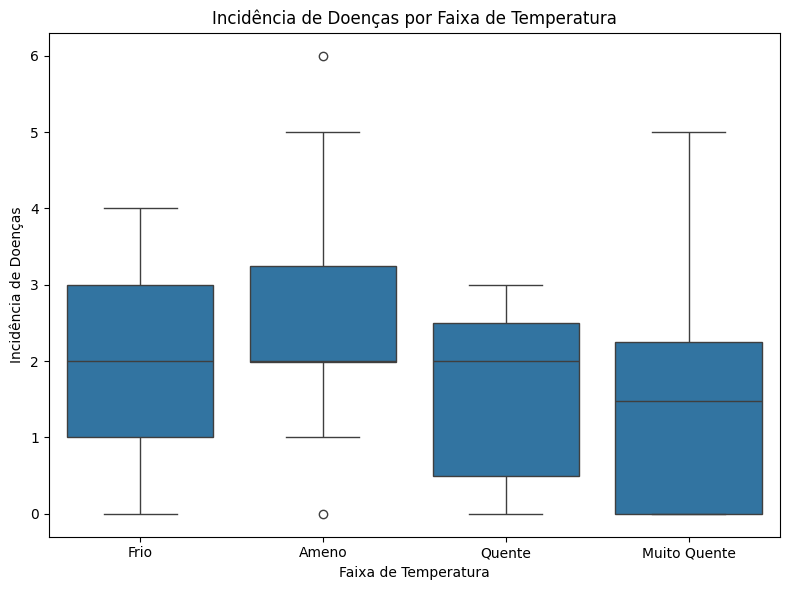

In [19]:
base_temperatura = base_completa.copy()
base_temperatura['faixa_temperatura'] = pd.qcut(base_temperatura['temperatura_media_C'], q=4, labels=["Frio", "Ameno", "Quente", "Muito Quente"])

plt.figure(figsize=(8, 6))
sns.boxplot(data=base_temperatura, x='faixa_temperatura', y='incidencia_doencas')
plt.title("Incidência de Doenças por Faixa de Temperatura")
plt.xlabel("Faixa de Temperatura")
plt.ylabel("Incidência de Doenças")
plt.tight_layout()
plt.show()

# 14. Visualização: Produção por Faixas de Segurança Alimentar
Nesta etapa, analisamos a relação entre a segurança alimentar e a produção agrícola.

C:\Users\usuario\AppData\Local\Temp\ipykernel_15568\3092530177.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=base_seg, x='faixa_seguranca', y='volume_producao_tons', palette="Set2")


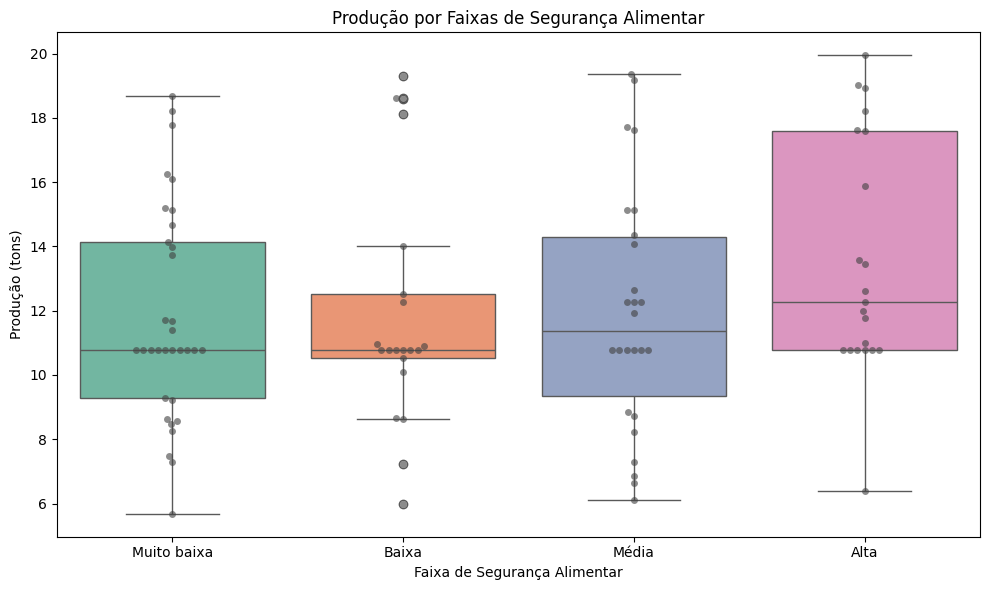

In [30]:
base_seg = base_completa.copy()

# ① converte para float, cria faixas de 0–25–50–75–100
base_seg['faixa_seguranca'] = pd.cut(
    base_seg['indicador_seguranca_alimentar'].astype(float),
    bins=[0, 25, 50, 75, 100],
    labels=['Muito baixa', 'Baixa', 'Média', 'Alta'],
    include_lowest=True
)

plt.figure(figsize=(10, 6))
sns.boxplot(data=base_seg, x='faixa_seguranca', y='volume_producao_tons', palette="Set2")
sns.swarmplot(data=base_seg, x='faixa_seguranca', y='volume_producao_tons', color=".25", alpha=0.6)

plt.title("Produção por Faixas de Segurança Alimentar")
plt.xlabel("Faixa de Segurança Alimentar")
plt.ylabel("Produção (tons)")
plt.tight_layout()
plt.show()

# 15. Heatmap: Correlação entre Variáveis Numéricas
Calculamos a matriz de correlação entre variáveis quantitativas e a exibimos com um heatmap.

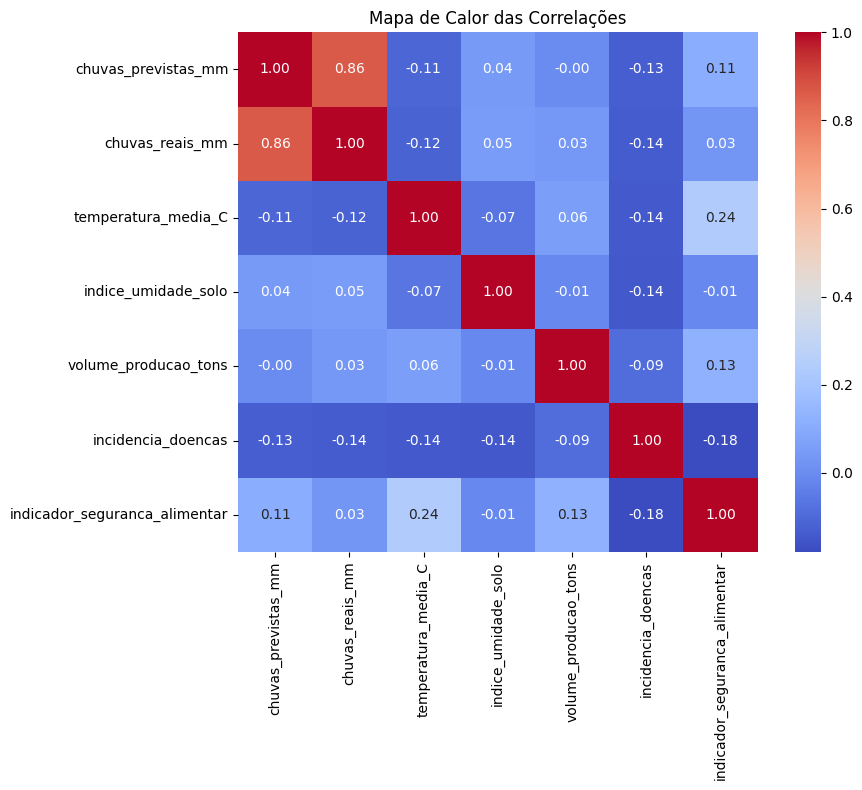

In [20]:
numericas = ['chuvas_previstas_mm', 'chuvas_reais_mm', 'temperatura_media_C',
             'indice_umidade_solo', 'volume_producao_tons', 
             'incidencia_doencas', 'indicador_seguranca_alimentar']

correlacao = base_completa[numericas].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Mapa de Calor das Correlações")
plt.tight_layout()
plt.show()